##### Copyright 2021 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Imports

In [ ]:
import sys

!git clone https://github.com/google-research/google-research.git
sys.path.append('./google-research')

In [ ]:
import numpy as np
import tensorflow.compat.v1 as tf
import matplotlib
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm
tf.disable_eager_execution()

from blur import blur
from blur import blur_env
from blur import blur_meta
from blur import genome_util
from blur import synapse_util
from blur.data import func2d

matplotlib.rcParams.update({'font.size': 18})

# Using fixed (gradient) genome

First we are going to explore the beahvior of hand-designed "gradient" genome. This genome is located in `genome_util.GRADIENT_GENOME`, and is designed to mimic back propagation. However it is not precise backpropagation, because of local activations effects. 

In [ ]:
def batch_dataset(ds,
                  batch_size=16,
                  species=None,
                  replicas=None,
                  drop_remainder=True):
  """Batches dataset."""
  replicas = 1 if replicas is None else replicas
  species = 1 if species is None else species
  ds = ds.batch(batch_size, drop_remainder=drop_remainder)
  ds = ds.batch(replicas, drop_remainder=drop_remainder)
  ds = ds.batch(species, drop_remainder=drop_remainder)
  return ds

def create_2d_dataset(
    bin_batch_fn, batch_size=16, replicas=None, species=None, inner_batch_size=10000):
  """Creates 2d function tf.data.Dataset from a given bin_fn."""

  def generator():
    yield bin_batch_fn(inner_batch_size)

  ds = tf.data.Dataset.from_generator(
      generator, output_types=(tf.float32, tf.float32),
      output_shapes=((inner_batch_size, 2), (inner_batch_size, 1)))
  ds = ds.repeat().unbatch()
  ds = batch_dataset(ds, batch_size=batch_size, species=species, replicas=replicas)
  return ds

In [ ]:
#@title Gradient descent on genome {display-mode: "form"}

def loss_fn(states):
  return -blur_meta.l2_score_per_species(states)

def save_genome(sess, genome):
  genome_tensors = genome_util.convert_genome_to_dict(genome)
  return {name: sess.run(var) for name, var in genome_tensors.items()}

def build_states(tasks, batch_size, replicas=None, species=None, **params):
  inner_batch_size = batch_size * unroll_steps
  states = {}
  for task, bin_fn in tasks.items():
    ds = create_2d_dataset(
        bin_fn, batch_size=batch_size, inner_batch_size=inner_batch_size,
        replicas=replicas, species=species)
    states[task] = blur_meta.build_graph(data=ds, **params)
  return states

def run_experiment(
    train_tasks,
    val_tasks,
    synapse_initializer_fn=synapse_util.fixed_random_initializer,
    hidden_layers=(20, ),
    unroll_steps=5,
    batch_size=512,    
    learning_rate=0.001,
    genome=genome_util.GRADIENT_GENOME,
    num_neuron_states=2,
    species=1,
    replicas=1,    
    num_steps=100000,
    log_every=50):
  """Run BLUR meta-training."""
  tf.reset_default_graph()
  genome = genome_util.convert_genome_to_tf_variables(genome)
  network_spec = blur.default_network_spec(blur_env.tf_env)
  params = dict(batch_size=batch_size, 
                synapse_initializer=synapse_initializer_fn(),
                unroll_steps=unroll_steps,
                genome=genome,
                hidden_layers=hidden_layers,
                species=species,
                replicas=replicas)

  train_states = build_states(train_tasks, **params)
  val_states = build_states(val_tasks, **params)

  loss = tf.add_n([loss_fn(v) for v in train_states.values()]) / len(train_states)
  loss = tf.reduce_sum(loss, axis=0)

  train_op = tf.train.AdamOptimizer(learning_rate,).minimize(loss)
  init_op = tf.group(tf.local_variables_initializer(),
                     tf.global_variables_initializer())

  tasks = list(train_states.items()) + list(val_states.items())
  accuracy = {}
  input_data = {}
  prediction = {}
  ground_truth = {}

  for task in tasks:
    name, states = task
    inp = [state.layers[0][..., 0] for state in states]
    pred = [state.layers[-1][..., 0] for state in states]
    gt = [state.ground_truth for state in states]
    accuracy[name] = []
    for p, g in zip(pred, gt):
      agreed = (p * g) > 0
      accuracy[name].append(tf.reduce_sum(tf.cast(agreed, tf.float32) / batch_size, axis=-2))
    input_data[name] = inp
    prediction[name] = pred
    ground_truth[name] = gt
  stats = collections.defaultdict(list)
  with tf.Session() as s:
    s.run(init_op)
    for it in tqdm(range(num_steps)):
      s.run(train_op)
      if it % log_every == 0:
        v_in, v_pred, v_acc, v_gt = s.run([input_data, prediction, accuracy, ground_truth])
        stats['input_data'].append(v_in)
        stats['prediction'].append(v_pred)
        stats['accuracy'].append(v_acc)
        stats['ground_truth'].append(v_gt)
        stats['genome'].append(save_genome(s, genome))
  return stats

In [ ]:
#@title SGD using per task specific initialization
tf.reset_default_graph()
train_tasks = {'xor': func2d.xor,
               'or': func2d.bool_or,
               }
val_tasks = {'and': func2d.bool_and,
             'nand': func2d.bool_qand,
             'nxor': func2d.nxor,
             }
all_tasks = list(train_tasks.keys()) + list(val_tasks.keys())
num_tasks = len(all_tasks)

num_steps = 1000
log_every = 50
unroll_steps = 5
hidden_layers = (20,)
genome = genome_util.GRADIENT_GENOME
synapse_initializer_fn = synapse_util.fixed_random_initializer

tf.compat.v1.set_random_seed(0)
stats = run_experiment(
    train_tasks=train_tasks,
    val_tasks=val_tasks,
    num_steps=num_steps,
    log_every=log_every,
    genome=genome,
    unroll_steps=unroll_steps,
    synapse_initializer_fn=synapse_initializer_fn,
    hidden_layers=hidden_layers)

100%|██████████| 1000/1000 [00:40<00:00, 24.52it/s]


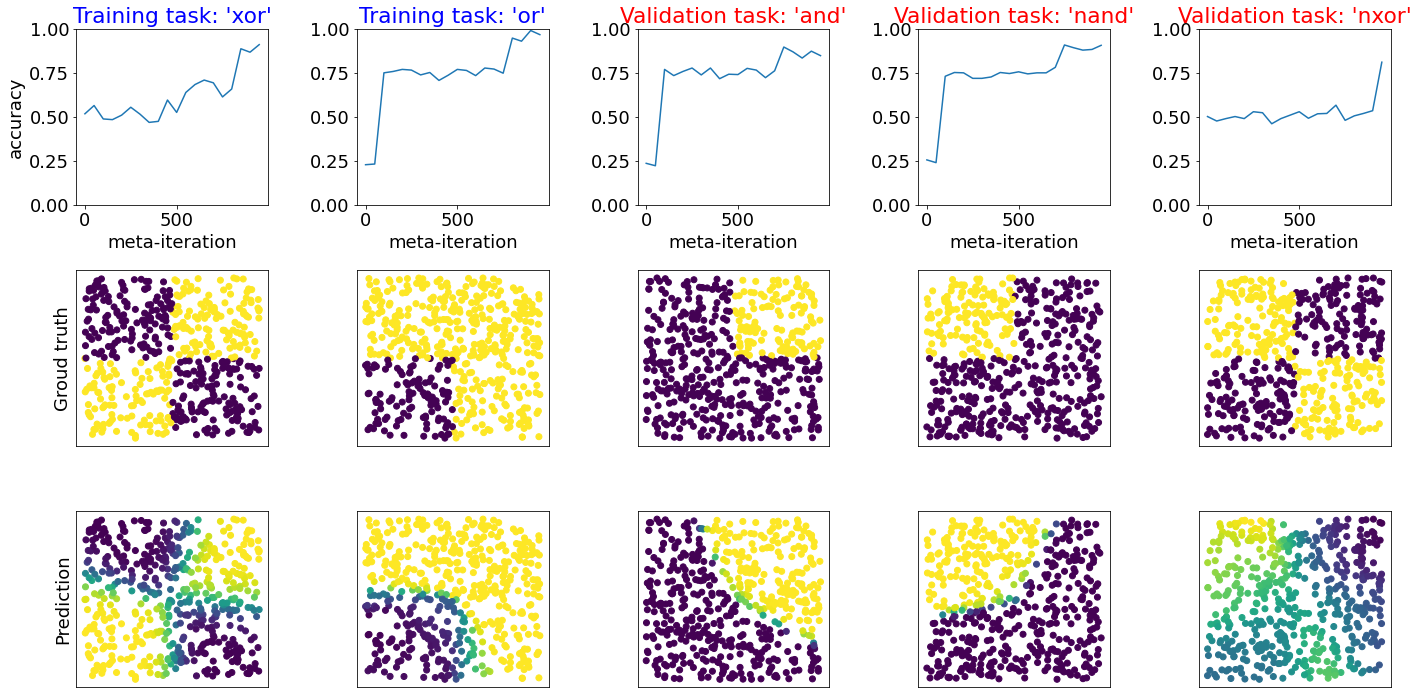

In [ ]:
#@title Meta-training dynamics

fig = plt.figure(figsize=(num_tasks * 4, 10))
for i, task in enumerate(all_tasks):
  acc = np.squeeze([a[task] for a in stats['accuracy']])[:, -1]
  inp = np.squeeze(stats['input_data'][-1][task][-1])
  pred = np.squeeze(stats['prediction'][-1][task][-1])
  gt = np.squeeze(stats['ground_truth'][-1][task][-1])
  ax1 = plt.subplot(3, num_tasks, i+1)
  steps = range(0, num_steps, log_every)
  plt.plot(steps, acc)
  plt.ylim([0, 1])
  if task in train_tasks.keys():
    ax1.set_title(f"Training task: '{task}'", color='b')
  else:
    ax1.set_title(f"Validation task: '{task}'", color='r')
  plt.xlabel('meta-iteration')
  if i == 0:
    plt.ylabel('accuracy')

  plt.subplot(3, num_tasks, i + num_tasks + 1)
  plt.scatter(inp[:, 0], inp[:, 1], c=gt)
  plt.xticks([], [])
  plt.yticks([], [])
  if i == 0:
    plt.ylabel('Groud truth')

  plt.subplot(3, num_tasks, i + 2*num_tasks + 1)
  plt.scatter(inp[:, 0], inp[:, 1], c=pred)
  plt.xticks([], [])
  plt.yticks([], [])
  if i == 0:
    plt.ylabel('Prediction')

plt.tight_layout(pad=1.0)

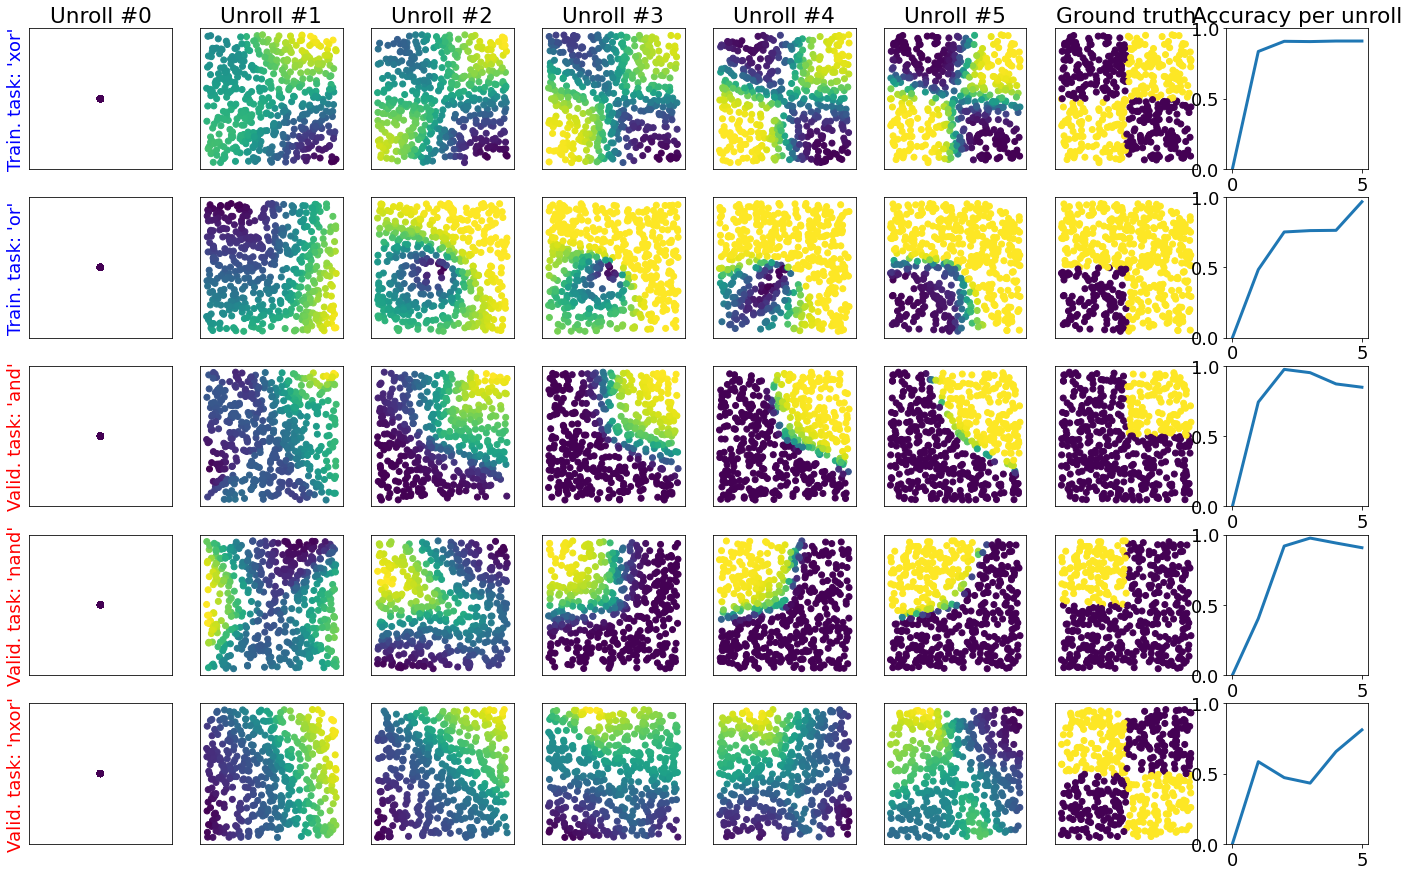

In [ ]:
#@title Unroll dynamic for the final genome

fig = plt.figure(figsize=((unroll_steps + 3) * 3, num_tasks * 3))
for t, task in enumerate(all_tasks):
  inp = stats['input_data'][-1][task]
  pred = stats['prediction'][-1][task]
  gt = stats['ground_truth'][-1][task]
  acc = np.squeeze(np.array(stats['accuracy'][-1][task]))
  for u, [inp_unroll, pred_unroll] in enumerate(zip(inp, pred)):
    plt.subplot(num_tasks, unroll_steps + 3, t * (unroll_steps + 3) + u + 1)
    inp_unroll = np.squeeze(inp_unroll)
    pred_unroll = np.squeeze(pred_unroll)
    plt.scatter(inp_unroll[:, 0], inp_unroll[:, 1], c=pred_unroll)
    plt.xticks([], [])
    plt.yticks([], [])
    if t == 0:
      plt.title(f'Unroll #{u}')
    if u == 0:
      if task in train_tasks.keys():
        plt.ylabel(f"Train. task: '{task}'", color='b')
      else:
        plt.ylabel(f"Valid. task: '{task}'", color='r')
  plt.subplot(num_tasks, unroll_steps + 3, (t + 1) * (unroll_steps + 3) - 1)
  inp = np.squeeze(inp[-1])
  gt = np.squeeze(gt[-1])
  plt.scatter(inp[:, 0], inp[:, 1], c=gt)
  plt.xticks([], [])
  plt.yticks([], [])
  if t == 0:
    plt.title('Ground truth')
  plt.subplot(num_tasks, unroll_steps + 3, (t + 1) * (unroll_steps + 3))
  plt.plot(acc, lw=3)
  plt.ylim([0, 1])
  if t == 0:
    plt.title('Accuracy per unroll')

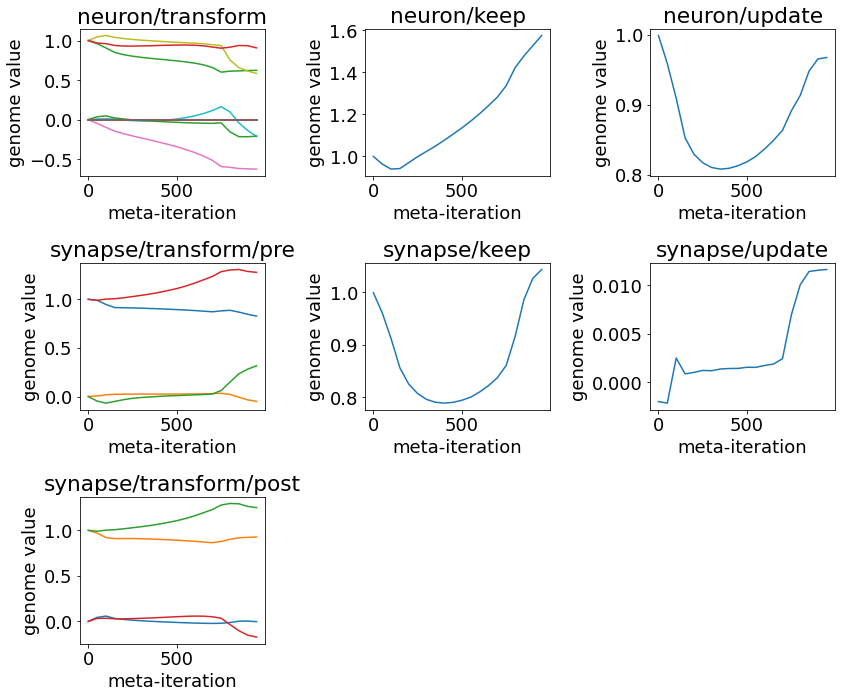

In [ ]:
#@title Meta-training dynamics for the genome elements
genome_elements = ['neuron/transform',
                   'neuron/keep',
                   'neuron/update',
                   'synapse/transform/pre',
                   'synapse/keep',
                   'synapse/update',
                   'synapse/transform/post',
                   ]
steps = range(0, num_steps, log_every)
fig = plt.figure(figsize=(12, 10))
for i, el in enumerate(genome_elements):
  gen_el = np.array([gen[el] for gen in stats['genome']]).reshape((len(steps), -1))
  plt.subplot(3, 3, i+1)
  plt.plot(steps, gen_el)
  plt.title(el)
  plt.xlabel('meta-iteration')
  plt.ylabel('genome value')
plt.tight_layout(pad=1.0)

# Running Multi-species gradient descent

Sometimes we observe that random training run doesn't converge. So here we run `multi-species` experiments, that starts with multiple genomes and run them in parallel.


In [ ]:
#@title Training 4 species in a single experiment.
num_species = 4
num_replicas = 1
neuron_states = 2
num_steps = 1500
log_every = 50
unroll_steps = 5
hidden_layers = (32,)
train_tasks = {'xor': func2d.xor,
               'or': func2d.bool_or,
               }
val_tasks = {'and': func2d.bool_and,
             'nand': func2d.bool_qand,
             'nxor': func2d.nxor,
             }
genome = genome_util.create_random_genome(neuron_states, num_species=num_species)
synapse_initializer_fn = synapse_util.fixed_random_initializer

tf.compat.v1.set_random_seed(0)
stats = run_experiment(
    train_tasks=train_tasks,
    val_tasks=val_tasks,
    num_steps=num_steps,
    log_every=log_every,
    genome=genome,
    unroll_steps=unroll_steps,
    learning_rate=0.001,
    species=num_species,
    replicas=num_replicas,
    synapse_initializer_fn=synapse_initializer_fn,
    hidden_layers=hidden_layers)

100%|██████████| 1500/1500 [04:03<00:00,  6.15it/s]


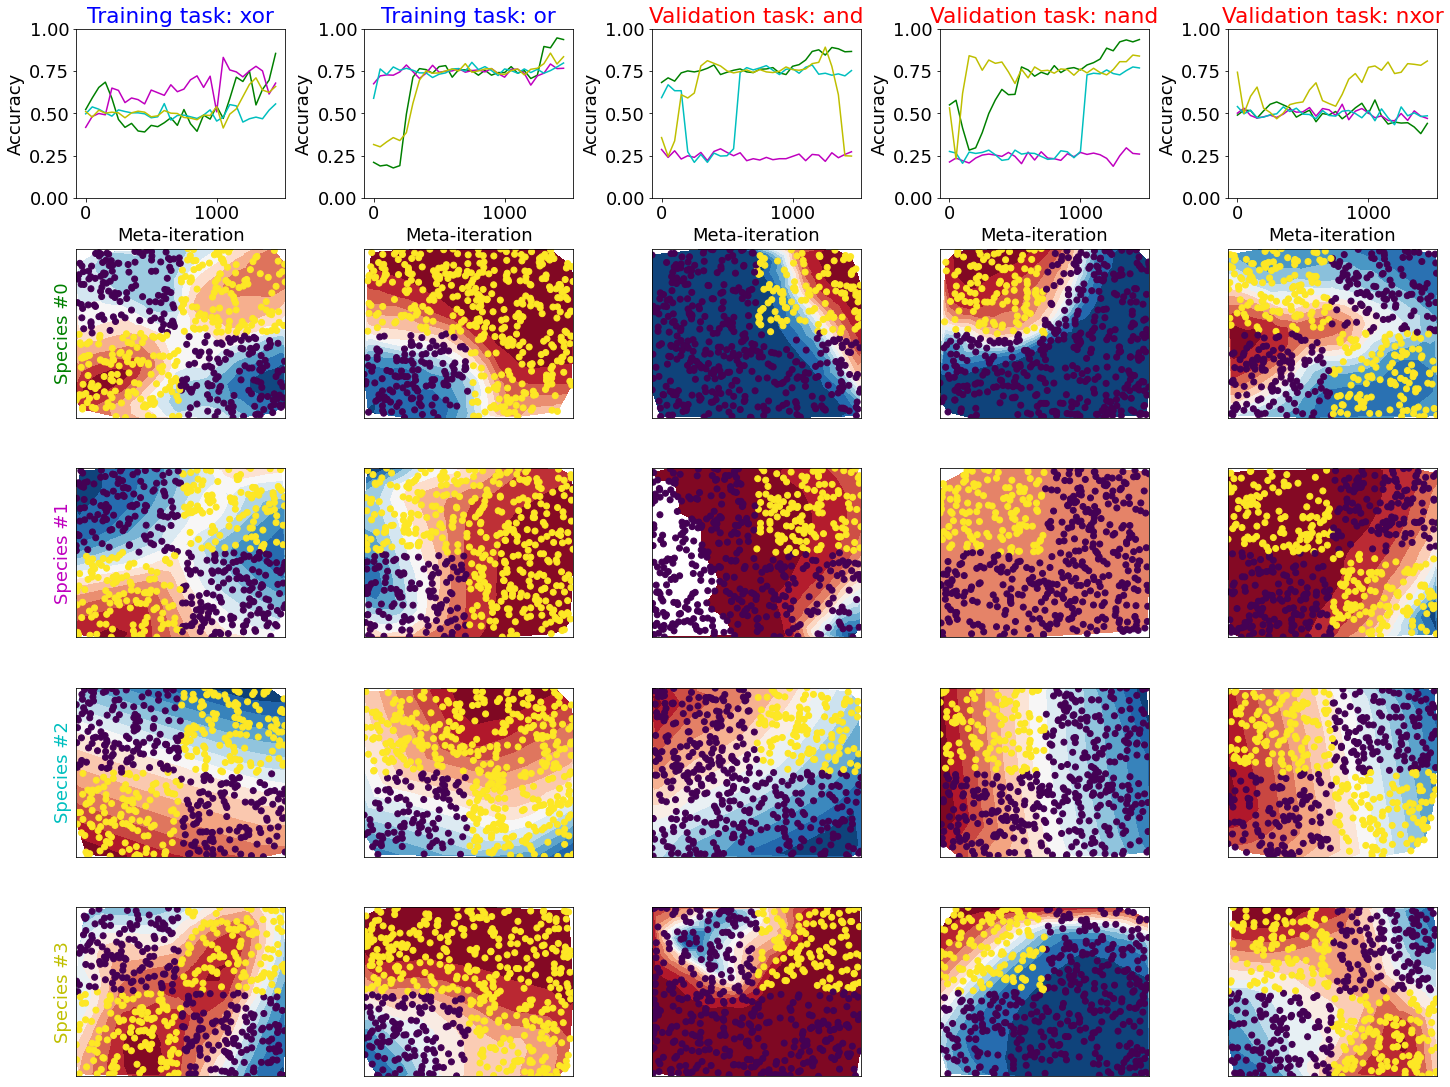

In [ ]:
#@title Meta-training dynamics
all_tasks = list(train_tasks.keys()) + list(val_tasks.keys())
num_tasks = len(all_tasks)
plt.figure(figsize=(num_tasks * 4, (num_species + 1) * 3))
colors = ['g', 'm', 'c', 'y']
for i, task in enumerate(all_tasks):
  acc = np.array([a[task][-1] for a in stats['accuracy']])
  inp = stats['input_data'][-1][task][-1]
  pred = stats['prediction'][-1][task][-1]
  gt = stats['ground_truth'][-1][task][-1]

  ax1 = plt.subplot(num_species + 1, num_tasks, i+1)
  steps = range(0, num_steps, log_every)
  for s in range(num_species):
    for r in range(num_replicas):
      plt.plot(steps, acc[:, s, r, :], c=colors[s], label=f'Species {s}')
  plt.ylim([0, 1])
  if task in train_tasks.keys():
    ax1.set_title('Training task: ' + task, color='b')
  else:
    ax1.set_title('Validation task: ' + task, color='r')
  plt.xlabel('Meta-iteration')
  plt.ylabel('Accuracy')
  #plt.legend()

  r = 0
  for s in range(num_species):
    plt.subplot(num_species + 1, num_tasks, i + num_tasks * (s+1) + 1)
    plt.tricontourf(inp[s, r, :, 0], inp[s, r, :, 1], pred[s, r, :, 0], 14, cmap='RdBu_r')
    plt.scatter(inp[s, r, :, 0], inp[s, r, :, 1], c=gt[s, r, :])
    plt.xticks([], [])
    plt.yticks([], [])
    if i == 0:
      plt.ylabel(f'Species #{s}', c=colors[s])
plt.tight_layout(pad=0.2)